In [47]:
#pip install tensorflow

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [49]:
# Import datasets
text_data = pd.read_csv(r"C:\Users\DELL\Downloads\classification_dataset.csv")
with open(r"C:\Users\DELL\Downloads\generation_corpus.txt", "r") as f:
    gen_text = f.read()

In [50]:
# Classification preprocessing
tokenizer_cls = Tokenizer()
tokenizer_cls.fit_on_texts(text_data['text'])
X_cls = tokenizer_cls.texts_to_sequences(text_data['text'])
X_cls = pad_sequences(X_cls, padding='post')

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(text_data['label'])
y_cls = label_tokenizer.texts_to_sequences(text_data['label'])
y_cls = np.array(y_cls) - 1
y_cls = to_categorical(y_cls)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)


In [51]:
# Generation preprocessing
clean_text = gen_text.lower().replace('\n', ' ')
clean_text = re.sub(r'[^\w\s]', '', clean_text)

tokenizer_gen = Tokenizer()
tokenizer_gen.fit_on_texts([clean_text])
total_words = len(tokenizer_gen.word_index) + 1

input_sequences = []
words = clean_text.split()
for i in range(3, len(words)):
    seq = words[i-3:i+1]
    line = tokenizer_gen.texts_to_sequences([' '.join(seq)])[0]
    input_sequences.append(line)

input_sequences = np.array(input_sequences)
X_gen, y_gen = input_sequences[:,:-1], input_sequences[:,-1]
y_gen = to_categorical(y_gen, num_classes=total_words)


In [52]:
# Print shapes to verify
print("Classification input shape:", X_train_cls.shape)
print("Generation input shape:", X_gen.shape)

Classification input shape: (240, 18)
Generation input shape: (627, 3)


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model_cls = Sequential([
    Embedding(input_dim=len(tokenizer_cls.word_index) + 1, output_dim=64),
    SimpleRNN(64),
    Dense(32, activation='relu'),
    Dense(y_cls.shape[1], activation='softmax')  # Output layer for 3 classes
])

model_cls.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cls.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [54]:
model_gen = Sequential([
    Embedding(input_dim=total_words, output_dim=64),
    SimpleRNN(64),
    Dense(total_words, activation='softmax')  # Predict next word from vocab
])

model_gen.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gen.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Train the classification model
model_cls.fit(X_train_cls, y_train_cls, epochs=10, validation_data=(X_test_cls, y_test_cls))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.5625 - loss: 1.0290 - val_accuracy: 1.0000 - val_loss: 0.7371
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.6225 - val_accuracy: 1.0000 - val_loss: 0.2596
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.2222 - val_accuracy: 1.0000 - val_loss: 0.0653
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0531 - val_accuracy: 1.0000 - val_loss: 0.0203
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 1.0000 - val_loss: 0.0081
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0023


In [56]:
# Train the classification model
history_cls = model_cls.fit(
    X_train_cls, y_train_cls,
    epochs=10,
    validation_data=(X_test_cls, y_test_cls),
    verbose=1
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 9.3128e-04
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 9.1542e-04 - val_accuracy: 1.0000 - val_loss: 8.5610e-04
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 8.5203e-04 - val_accuracy: 1.0000 - val_loss: 7.8951e-04
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 7.9312e-04 - val_accuracy: 1.

In [57]:
# Evaluate model performance
loss_cls, acc_cls = model_cls.evaluate(X_test_cls, y_test_cls, verbose=0)
print(f" Classification Accuracy on Test Set: {acc_cls:.2f}")

sample_text = X_test_cls[0]
pred_class = model_cls.predict(np.expand_dims(sample_text, axis=0))

# Get the predicted class index
predicted_class_index = np.argmax(pred_class)
predicted_class = label_tokenizer.index_word[predicted_class_index + 1]  # Add 1 to match original class label

print(f"Predicted class for the sample text: {predicted_class}")

 Classification Accuracy on Test Set: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
Predicted class for the sample text: history


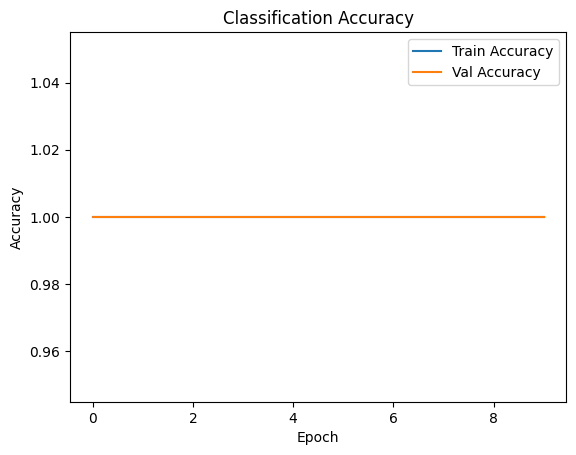

In [58]:
#
plt.plot(history_cls.history['accuracy'], label='Train Accuracy')
plt.plot(history_cls.history['val_accuracy'], label='Val Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [59]:
# Train the generation model
history_gen = model_gen.fit(X_gen, y_gen, epochs=30, verbose=1)


Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0808 - loss: 4.3122  
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5844 - loss: 4.1277
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6239 - loss: 3.7924
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5089 - loss: 3.1965
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6485 - loss: 2.3730
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7371 - loss: 1.7282
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8575 - loss: 1.2553
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9102 - loss: 0.9242
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9676 - loss: 0.6740
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9930 - loss: 0.5131
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.3954
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - 

In [60]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_next_words(seed_text, next_words=20):
    for _ in range(next_words):
        token_list = tokenizer_gen.texts_to_sequences([seed_text])[0][-3:]  # Last 3 tokens
        token_list = pad_sequences([token_list], maxlen=3, padding='pre')
        predicted = model_gen.predict(token_list, verbose=0)
        predicted_word_index = np.argmax(predicted)
        output_word = tokenizer_gen.index_word.get(predicted_word_index, '')
        seed_text += ' ' + output_word
    return seed_text



In [61]:
# Example usage
seed_sentence = "photosynthesis is the process"
generated_text = generate_next_words(seed_sentence, next_words=20)
print("Generated Text:\n", generated_text)


Generated Text:
 photosynthesis is the process the sunlight produced during and is released into the atmosphere this process is fundamental to life on earth as it


In [96]:
from keras.models import load_model

model = load_model('model_cls.keras', compile=False)  # Don't load optimizer state
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [98]:
from keras.saving import save_model
save_model(model_cls, 'model_cls.keras')
model.save('model_cls.keras', include_optimizer=False)


In [100]:
import pickle
from tensorflow.keras.models import load_model

# Assuming your model is a Keras model
model = load_model("model_cls.keras")

# Save model as pickle
with open('classification_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the label names (if you have them)
label_names = ['History', 'Science', 'Math']  # Replace with actual label names
with open('label_names.pkl', 'wb') as f:
    pickle.dump(label_names, f)



C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [104]:
model_gen.save('model_gen.keras')
# Correct file name and format
from keras.models import load_model
model_gen = load_model('model_gen.keras')  # If saved as .keras


In [106]:

# Assuming your model is a Keras model
model = load_model('model_gen.keras')

# Save model as pickle
with open('next_word_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the tokenizer (use the one you trained with)
tokenizer = Tokenizer()  # Replace with actual tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
